In [1]:
%load_ext autoreload
%autoreload 3

In [16]:
from fsddpm.datasets.colored_mnist import get_dataset 

import matplotlib.pyplot as plt
from torch import nn
import torch
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import numpy as np
import torch.nn.functional as F
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [17]:
def tensor2img(tensor):
    return ((tensor.cpu().clip(-1, 1) + 1)/2).permute(1,2,0)

In [175]:
device = 'cuda'
BATCH_SIZE = 128

train_ds, test_ds = get_dataset('/ssd_new/r.fazylov/tmp/')
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

# VAE

In [176]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        conv_features_shape = (96, 14, 14)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 96, 3, padding='same'),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, padding='same'),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(np.prod(conv_features_shape), 32),
            nn.ReLU(),
            nn.Linear(32, 2*latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 96*14*14),
            nn.Unflatten(dim=1, unflattened_size=(96, 14, 14)),
            nn.ConvTranspose2d(96, 96, kernel_size=2, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 3, padding='same', kernel_size=3),
            # nn.Sigmoid()
            # nn.Tanh()
        )
        
    def reparam(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
        
    def forward(self, x):
        mu, log_var = self.encoder(x).chunk(2, dim=1)
        z = self.reparam(mu, log_var)
        return self.decoder(z), mu, log_var

In [177]:
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = torch.mean(F.mse_loss(x, recon_x, reduction='none'), axis=(1,2,3))
    
    # recon_loss = torch.mean(F.binary_cross_entropy(recon_x, x, reduction='none'), axis=(1,2,3))
    # print(recon_x.shape, x.shape, recon_loss.shape)
    kl_loss = -5e-4 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp(), axis=-1)
    return torch.mean(recon_loss + kl_loss), torch.mean(recon_loss), torch.mean(kl_loss)

In [178]:
LATENT_DIM = 6
vae = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [179]:
from torchinfo import summary
summary(vae, input_size=(1, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 28, 28]            --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─ReLU: 2-3                         [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 14, 14]           128
│    └─ReLU: 2-6                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-7                       [1, 96, 14, 14]           55,392
│    └─BatchNorm2d: 2-8                  [1, 96, 14, 14]           192
│    └─ReLU: 2-9                         [1, 96, 14, 14]           --
│    └─Conv2d: 2-10                      [1, 96, 14, 14]           83,040
│    └─ReLU: 2-11                        [1, 96, 14, 14]           --


In [180]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRecon Loss: {:.6f}\tKL Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader),
                100. * batch_idx / len(train_loader), loss.item(), recon_loss, kl_loss))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader)))

In [181]:
def test():
    vae.eval()
    test_loss = 0
    test_loss_recon = 0
    test_loss_kl = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            loss, recon_loss, kl_loss = vae_loss(recon, data, mu, log_var)
            test_loss += loss.item()
            test_loss_recon += recon_loss.item()
            test_loss_kl += kl_loss.item()
        
    test_loss /= len(test_loader)
    test_loss_recon /= len(test_loader)
    test_loss_kl /= len(test_loader)
    print('====> Test set loss: {:.4f}, recon {:.4f}, KL {:.4f}'.format(test_loss, test_loss_recon, test_loss_kl))

In [182]:
for epoch in tqdm(range(75)):
    train(epoch)
    test()

  0%|          | 0/75 [00:00<?, ?it/s]

Train Epoch: 0 [0/469 (0%)]	Loss: 1.199490	Recon Loss: 1.199472	KL Loss: 0.000018
Train Epoch: 0 [12800/469 (21%)]	Loss: 0.151229	Recon Loss: 0.147520	KL Loss: 0.003709
Train Epoch: 0 [25600/469 (43%)]	Loss: 0.125478	Recon Loss: 0.121931	KL Loss: 0.003547
Train Epoch: 0 [38400/469 (64%)]	Loss: 0.113379	Recon Loss: 0.109958	KL Loss: 0.003420
Train Epoch: 0 [51200/469 (85%)]	Loss: 0.110061	Recon Loss: 0.106875	KL Loss: 0.003186
====> Epoch: 0 Average loss: 0.1366
====> Test set loss: 0.1084, recon 0.1053, KL 0.0032
Train Epoch: 1 [0/469 (0%)]	Loss: 0.102110	Recon Loss: 0.098987	KL Loss: 0.003124
Train Epoch: 1 [12800/469 (21%)]	Loss: 0.104705	Recon Loss: 0.101454	KL Loss: 0.003251
Train Epoch: 1 [25600/469 (43%)]	Loss: 0.094989	Recon Loss: 0.091586	KL Loss: 0.003403
Train Epoch: 1 [38400/469 (64%)]	Loss: 0.096409	Recon Loss: 0.093105	KL Loss: 0.003304
Train Epoch: 1 [51200/469 (85%)]	Loss: 0.099302	Recon Loss: 0.095887	KL Loss: 0.003416
====> Epoch: 1 Average loss: 0.1000
====> Test set 

# Sample

In [192]:
with torch.no_grad():
    z = torch.randn(64, LATENT_DIM).cuda()
    sample = vae.decoder(z).cuda()
    
    grid = make_grid(sample)

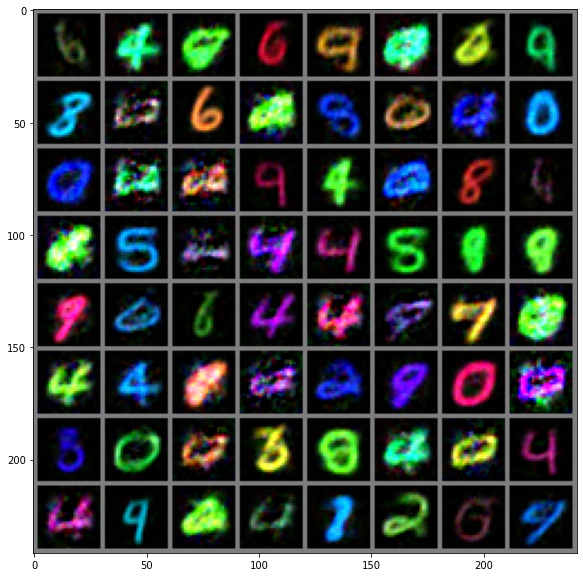

In [193]:
plt.figure(figsize=(10, 10))
plt.imshow(tensor2img(grid))

# Reconstruction

In [185]:
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x[:64]
    recon_x, _, _ = vae(x.to(device))
    
    orig_grid = make_grid(x)    
    recon_grid = make_grid(recon_x)

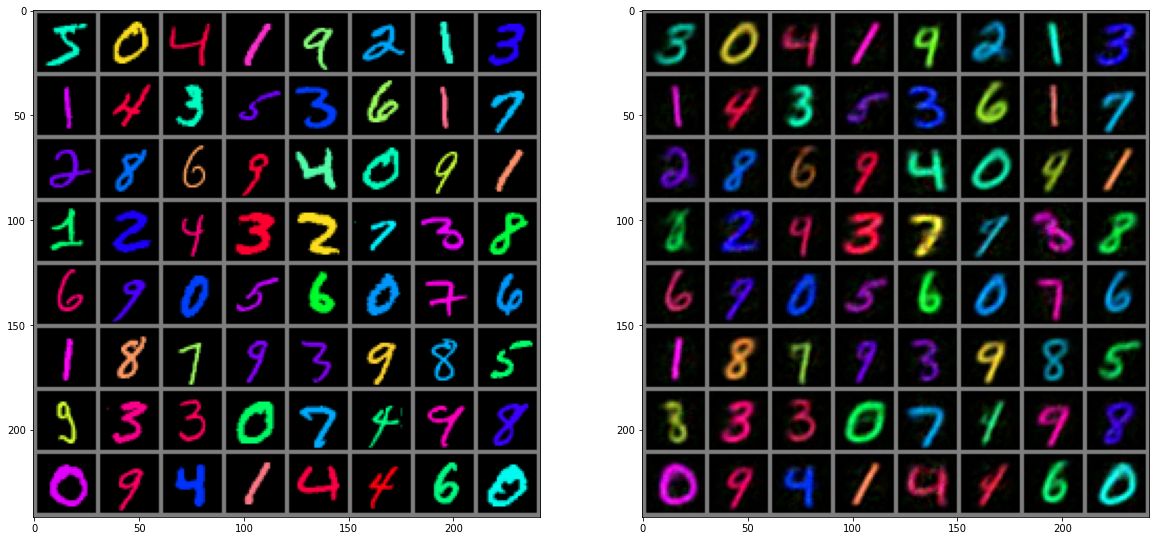

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(tensor2img(orig_grid))
ax[1].imshow(tensor2img(recon_grid))

In [194]:
torch.save(vae.state_dict(), './vae_param932k_latdim6_kl5e-4_epoch70_bs128.ckpt')